# Gaussian mixture model example

## Model

We are interested in estimating the labels and means of a Gaussian mixture model (GMM) given $N$ data points.
Specifically, we observe $Y_1,\dots,Y_N\overset{\mathrm{i.i.d.}}{\sim} \pi$, 
where $\pi$ is a GMM with $K\in\mathbb{N}$ Gaussian components:

$$
    \pi = \sum_{k=1}^K w_k \phi_{\mu_k,\tau_k}.
$$
Here, $\phi_{\mu,\sigma}$ is a $\mathcal{N}(\mu,\tau)$ distribution
which we parametrize with precision $\tau$.
We assume that the number of components $K$ is known, 
as are the precisions $\tau_k$ and weights $w_k$, $k=1,\dots,K$.

We can formulate the GMM as a hierarchical model by introducing discrete latent variables (labels)
$x_1,\dots,x_N\in\{1,\dots,K\}$
that indicate the component to which each observation belongs,
i.e., $y_n\sim\phi_{\mu_k,\sigma_k} \iff x_n=k$.
We can use the labels to rewrite the likelihood as a product over the sample and label indices:

$$
    \ell(y_{1:N}; \mu_{1:K}, x_{1:N}) 
    = \prod_{n=1}^N \prod_{k=1}^K (w_k \phi_{\mu_k,\tau_k}(y_n))^{\mathbb{I}(x_n=k)},
$$
where (by a slight abuse of notation) $\phi_{\mu,\tau}(y)$ is the density of a 
$\mathcal{N}(\mu,\tau)$ distribution evaluated at $y\in\mathbb{R}$.


### Prior distributions

We consider uninformative and independent prior distributions for each of the $K+N$ parameters.
Specifically, we use the known weights $w_{1:N}$ for each $x_n$ and 
assign an isotropic zero-mean Gaussian for the means:

$$
    X_n \sim \mathrm{Categorical}(w_1,\dots,w_N), \quad
    \mu_k \sim \mathcal{N}(0,\tau_0), \quad
    n\in[N] \text{ and } k\in[K],
$$
where we choose a label-common prior precision $\tau_0$.
In our experiemtns, $\tau_0=0.1$, reflecting little prior knowledge of the means $\mu_k$.


### Posterior distribution

We can write down the posterior density (up to proportionality)
by multiplying the likelihood and the priors:

$$
    p(x_{1:N},\mu_{1_K}\,|\,y_{1:N})\propto
    \left(\mathrm{Categorical}(w_1,\dots,w_N)^N \right) \times
    \left(\prod_{k=1}^K\phi_{0,\tau_0}(\mu_k)\right) \times
    \left(\prod_{n=1}^N \prod_{k=1}^K (w_k \phi_{\mu_k,\tau_k}(y_n))^{\mathbb{I}(x_n=k)}\right).
$$


### Gibbs sampling

We devise a Gibbs sampler to learn the labels and means of the GMM.
We first obtain the full conditional distributions,
which have a closed form due to the structure of the problem.

Specifically, the full conditional of each individual label $x_n$, $n\in[N]$ fixed,
can be obtained by working with the terms directly affected by $x_n$:

$$
    p(X_n=k\,|\,\mu_{1_K},y_{1:N})\propto 
    w_k\prod_{\tilde{k}}^K (w_{\tilde{k}} 
    \phi_{\mu_{\tilde{k}},\tau_{\tilde{k}}}(y_n))^{\mathbb{I}(k={\tilde{k}})}.
$$

In this case, all the indicator functions are 0 except for $\tilde{k}=k$, and so

$$
    p(X_n=k\,|\,\mu_{1_K},y_{1:N})\propto w_k\phi_{\mu_k,\tau_k}(y_n),
$$

a scaled Gaussian distribution.

Similarly, we can leverage the "complete the quadratic expression" trick to obtain the
full conditional of each mean $\mu_k$, which corresponds to a Gaussian centered at a scaled sample mean:

$$
    p(\mu_k\,|\,x_{1:N},y_{1:N})=\phi_{\tilde{y}_{(k)},\tilde{\tau}_{(k)}}(\mu_k),
$$

where $\tilde{y}_{(k)}$ and $\tilde{\tau}_{(k)}^2$ combine the sample 
(via the sample mean and sample variance) with the prior information on $\mu_k$ from the prior:

$$
    \tilde{y}_{(k)} = \frac{1}{\tilde{\tau}_{(k)}} \sum_{n=1}^N y_n \mathbb{I}(x_n=k),\\
    \tilde{\tau}_{(k)} =N_{(k)}+\tau_0,\\
    N_{(k)}=\sum_{n=1}^N \mathbb{I}(x_n=k).
$$

Here, $N_{(k)}$ is the number of samples currently in cluster $k$,
which ensures that only data points in each active cluster are averaged.
The quantity $N_{(k)}+\tau_0$ can be thought of as the posterior sample size,
which corresponds to the actual sample size plus the amount of information provided by the prior
in terms of sample size (denoted by the prior precision).

## Data generation

We generate $N=100$
from a mixture with $K=3$ Gaussians.
The true means are $\mu=(-7.5,0,7.5)$
with precisions $\tau_k=0.4$ for all $k$ and
with weights $w=(0.2,0.5,0.3)$.
Below we plot a histogram of the sample.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import sys,time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
import gibbs
from concrete import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [29]:
# data generation
np.random.seed(2023)
N=100
K=3
true_mu=np.array([-7.5,0,7.5])
true_tau=0.2*np.ones(3)
true_w=np.array([0.2,0.5,0.3])

x=np.random.choice(np.arange(K,dtype=int),size=N,p=true_w)
y=true_mu[x]+np.random.randn(N)/np.sqrt(true_tau[x])

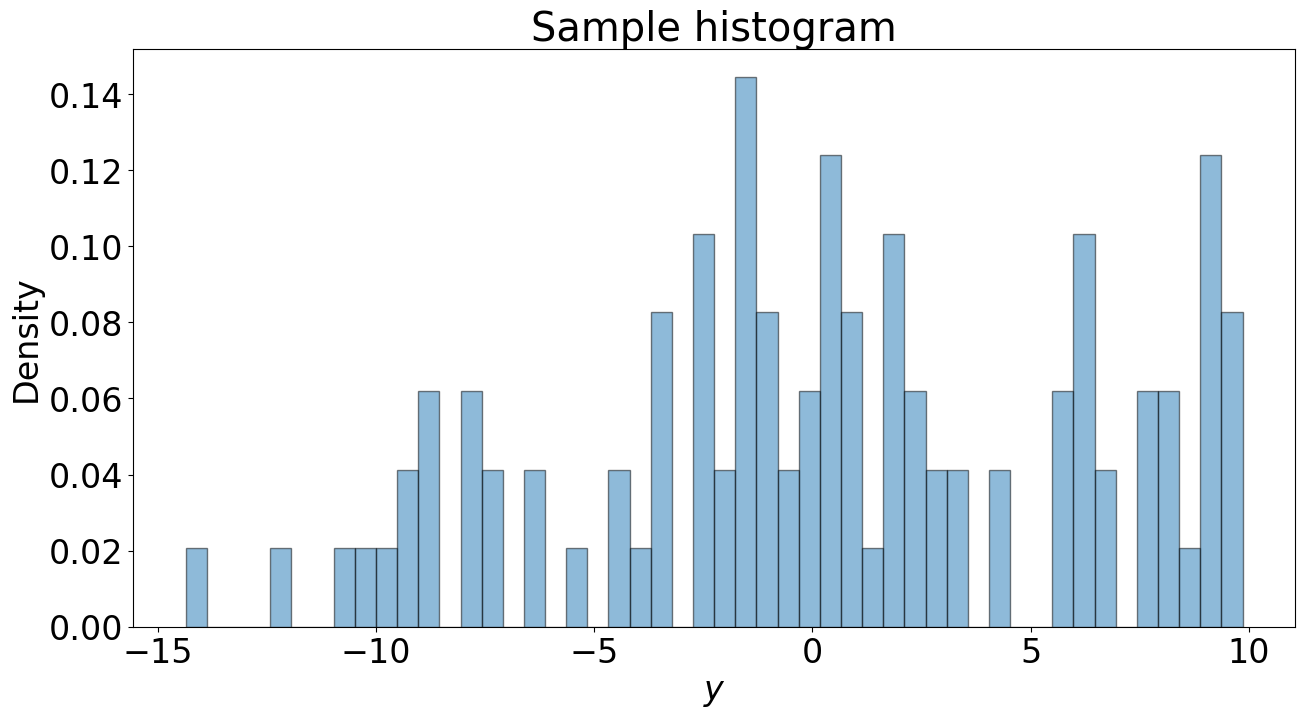

In [30]:
plt.hist(y,bins=50,alpha=0.5,ec='black',density=True)
plt.xlabel(r'$y$')
plt.ylabel('Density')
plt.title('Sample histogram');

## Gibbs sampler

Now we run a Gibbs sampler for 1,000 steps after burn-in 
(which will consist of 90% of the total steps taken,
i.e., we run 10,000 the sampler for 10,000 steps and take 
the last 1,000 as the sample).

In [31]:
tau0=0.1
steps=1000
pred_x,pred_mu=gibbs.gibbs_gmm(y,true_w,true_tau,tau0,steps,burnin_pct=0.9,verbose=True,seed=1)

In [32]:
print(np.mean(pred_mu,axis=-1))

[-8.37851971 -0.60716878  6.8633427 ]


In [33]:
confusion_matrix(x,pred_x[:,-1])

array([[18,  4,  0],
       [ 0, 42,  9],
       [ 0,  0, 27]])

In [34]:
# estimate probabilities of each xn
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,np.newaxis,np.newaxis],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[np.newaxis,:]).T

## Concrete approximation

In [21]:
########################
########################
#    Concrete          #
########################
########################
from IPython.display import clear_output
RUN=True # ONLY TRUE IF YOU WANT TO RERUN RESULTS

# TIME SUNK!!! RUN AT YOUR OWN PERIL
# simulation settings:
max_iters = 10001
temps     = np.array([0.1,0.5,1.,5.])
depths    = np.array([10,50,100])
layers    = np.array([32,64,128,256])
sim_size  = temps.shape[0]*depths.shape[0]*layers.shape[0]
#if RUN:
    # redefine arrays only if running from scratch
    #flows     = [0 for i in range(sim_size)]
    #losses    = np.zeros((sim_size,max_iters))
    #cpu_times = np.zeros(sim_size)

i=0
print('Training '+str(sim_size)+' flows')
for temp in temps:
    if not RUN: continue
    for depth in depths:
        for width in layers:
            i=i+1
            if i<11: continue
            print('Training flow '+str(i)+'/'+str(sim_size))
            print('Temperature: '+str(temp))
            print('Depth: '+str(depth))
            print('Width: '+str(width))
            t0 = time.perf_counter()
            conc_sample=gmm_concrete_sample(pred_x,pred_mu,temp)
            try:
                tmp_flow,tmp_loss=trainGMMRealNVP(
                    temp,depth,N,K,tau0,conc_sample,width,max_iters,lr=1e-3,mc_ss=1000,seed=0,verbose=True
                )
            except:
                tmp_flow,tmp_loss=None,None
            cpu_times[i]=time.perf_counter()-t0
            flows[i]=tmp_flow
            losses[i,:]=tmp_loss
            clear_output(wait=True)
        # end for
    # end for
# end for
clear_output(wait=True)
print('Done!')
print('Total training time: '+str(cpu_times.sum())+' seconds')

Training flow 48/48
Temperature: 5.0
Depth: 100
Width: 256


IndexError: index 48 is out of bounds for axis 0 with size 48

Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

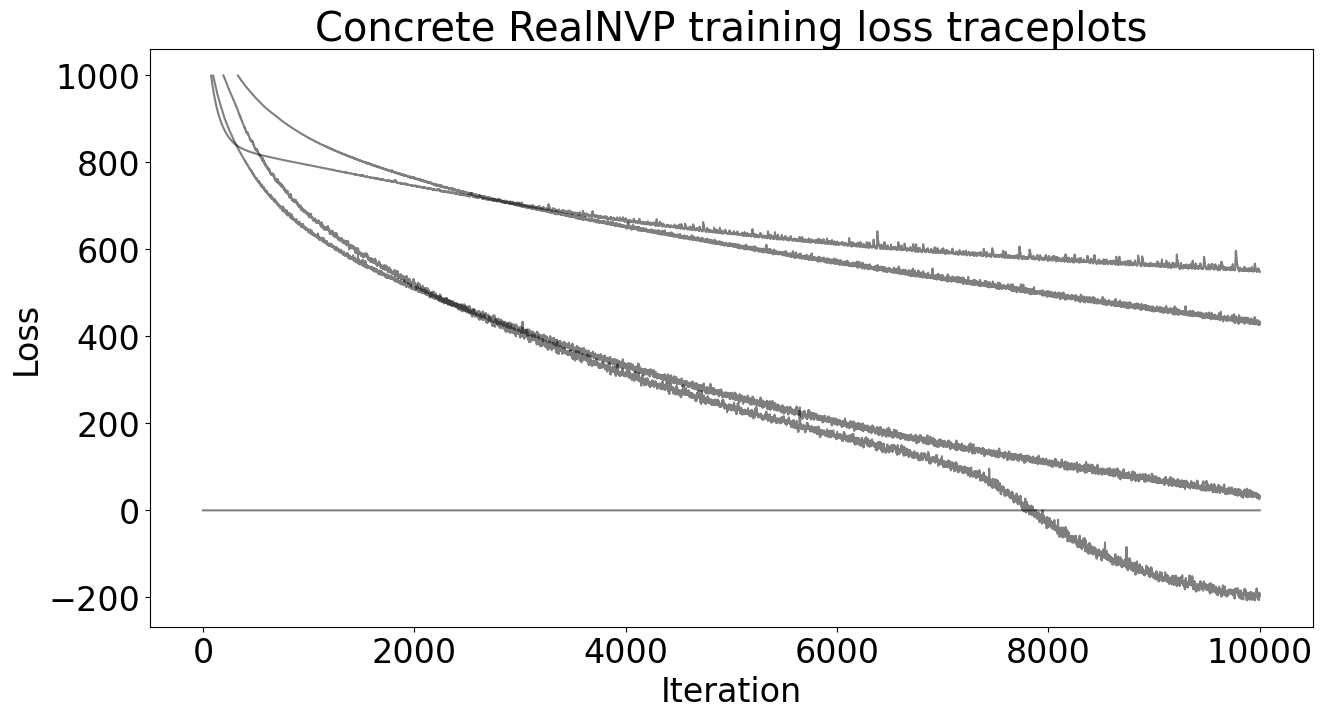

In [22]:
# loss traceplot
threshold=1000
for i in range(sim_size): plt.plot(np.arange(max_iters)[losses[i,:]<threshold],losses[i,losses[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

## Diagnostics

Text(0, 0.5, '$\\mathbb{P}(X=k)$')

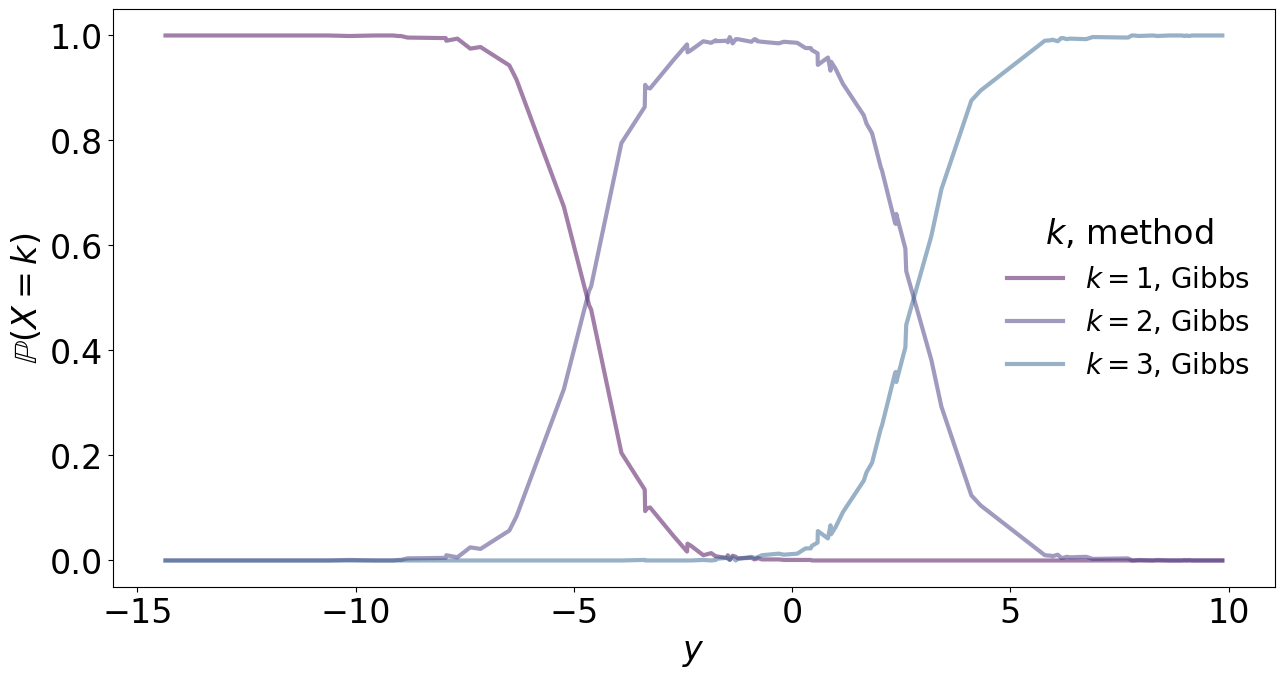

In [57]:
idx=np.argsort(y)

gibbs_colors=['#440154FF','#453781FF','#32648EFF']
plt.plot(y[idx],x_prbs[idx,0],label=r'$k=1$, Gibbs', color=gibbs_colors[0], alpha=0.5, lw=3)
plt.plot(y[idx],x_prbs[idx,1],label=r'$k=2$, Gibbs', color=gibbs_colors[1], alpha=0.5, lw=3)
plt.plot(y[idx],x_prbs[idx,2],label=r'$k=3$, Gibbs', color=gibbs_colors[2], alpha=0.5, lw=3)

plt.legend(fontsize='small',title=r'$k$, method',frameon=False)
plt.xlabel(r'$y$')
plt.ylabel(r'$\mathbb{P}(X=k)$')